# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
from pymystem3 import Mystem
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier


from nltk.corpus import stopwords as nltk_stopwords

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pasha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('/toxic_comments.csv')

In [3]:
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [6]:
data.duplicated().sum()

0

In [7]:
data['toxic'].unique()

array([0, 1], dtype=int64)

**Вывод:** данные изучили. Пропусков и дубликатов не обнаружено.

**Выкенем из сета данных столбец "Unnamed: 0", он дублирует индексацию**

In [8]:
data = data.drop(['Unnamed: 0'],axis=1)

In [9]:
data.shape

(159292, 2)

In [10]:
data.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


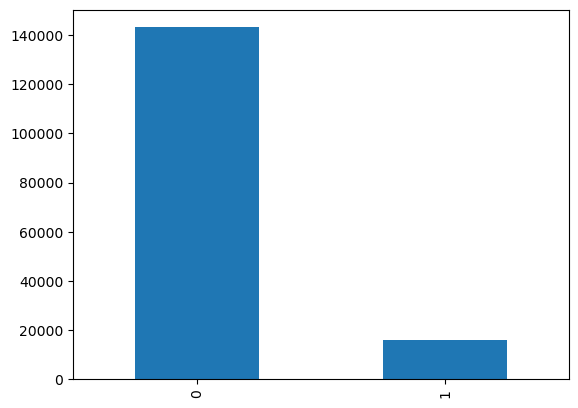

In [11]:
data['toxic'].value_counts().plot.bar();

**Вывод:** на столбчатой диаграмме заметен дисбаланс классов. Учтём это в будущем.

## Обучение

### Подготовка данных к обучению

In [12]:
data_train, data_sep = train_test_split(data,train_size=0.6, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_sep, test_size=0.5, random_state=12345)

**Проверка правильности разбиения данных**

In [13]:
round((len(data_train)/len(data))*100,2)

60.0

In [14]:
round((len(data_valid)/len(data))*100,2)

20.0

In [15]:
round((len(data_test)/len(data))*100,2)

20.0

**Лемматизация и очистка**

In [16]:
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])

In [17]:
def lemma(text):
    norm_text = []
    doc = nlp(text)
    for token in doc:
        if not token.is_punct and not token.is_stop and not token.is_space:
            norm_text.append(token.lemma_.lower())
    return ' '.join(norm_text)

In [18]:
data_train['lemm_text'] = data_train['text'].apply(lemma)

In [19]:
data_valid['lemm_text'] = data_valid['text'].apply(lemma)

In [20]:
data_test['lemm_text'] = data_test['text'].apply(lemma)

In [21]:
pd.options.display.max_colwidth = 200
data_test.head()

,text,toxic,lemm_text
67597,"""::I am not Goldberg and you can't prove otherwise because it is not true. I was blocked because MathKnight went whining about """"anti-semitism incitement"""" based on my User page and some admin app...",0,goldberg prove true block mathknight go whine anti semitism incitement base user page admin apparently believe rake blame personal attack prove typical gang enemy justification evidence thankfully...
102332,Wikipedia:Articles_for_deletion/List_of_Halo_multiplayer_maps \n\nHi. I reverted your closure here and closed with the same result because something about your closure was breaking the AFD counte...,0,wikipedia articles_for_deletion list_of_halo_multiplayer_maps hi revert closure close result closure break afd counter script let know concerns.v r p
24989,""">You claim I blame Poland for all of Germany's loss (which I don't) and then you go and blame Germany for all of Poland's loss, which is totally false!!!\n\nI only asked you if you blame Poland f...",0,> claim blame poland germany loss blame germany poland loss totally false ask blame poland german loss claim knowledge course soviet fault total 80 germans > petty nationalist borderline racist tr...
137235,"""which """"SMC""""/""""BMC"""" is being referred to? should link to the correct one, not a list""",0,"smc""""/""""bmc refer link correct list"
104605,"You fags need to go back to Golden Road with your butch masters John Sly and Marc Green \n\nI had a feeling you couldn't resist accusing all users of being Hdayejr, your hormones just aren't balan...",1,fag need golden road butch master john sly marc green feeling resist accuse user hdayejr hormone balance seriously die kind welcome earth live come introduce rope tree way wikipedia special edit i...


In [22]:
def clean(text):
    text = text.lower()
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(cleared_text.split())

In [23]:
data_train['lemm_text'] = data_train['lemm_text'].apply(clean)

In [24]:
data_valid['lemm_text'] = data_valid['lemm_text'].apply(clean)

In [25]:
data_test['lemm_text'] = data_test['lemm_text'].apply(clean)

**Подготовка признаков**

In [26]:
count_tf_idf = TfidfVectorizer()

Тренировочные

In [27]:
feature_train = count_tf_idf.fit_transform(data_train['lemm_text'])
target_train = data_train['toxic']

Валидационные

In [28]:
feature_valid = count_tf_idf.transform(data_valid['lemm_text'])
target_valid = data_valid['toxic']

Тестовые

In [29]:
feature_test = count_tf_idf.transform(data_test['lemm_text'])
target_test = data_test['toxic']

**Пробное обучение Логистической регрессии без баланса классов**

In [30]:
model = LogisticRegression(solver='liblinear').fit(feature_train,target_train)
pred = model.predict(feature_valid)
print('f1-score:',round(f1_score(target_valid,pred),3))

f1-score: 0.733


**Пробное обучение Логистической регрессии с балансом классов**

In [31]:
model = LogisticRegression(solver='liblinear',class_weight='balanced').fit(feature_train,target_train)
pred = model.predict(feature_valid)
print('f1-score balanced:',round(f1_score(target_valid,pred),3))

f1-score balanced: 0.752


**Вывод:** при балансе классов значение метрики f1 растет

### Проведем балансировку классов методом downsample

In [32]:
feature_train = data_train['lemm_text']
target_train = data_train['toxic']

In [33]:
def downsample(features,target,fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled,target_downsampled,random_state=12345)
    
    return features_downsampled, target_downsampled

In [34]:
features_downsampled, target_downsampled = downsample(feature_train,target_train, 0.3)

In [35]:
features_downsampled_ds = count_tf_idf.transform(features_downsampled)

**Модель логистической регрессии**

In [36]:
model = LogisticRegression(solver='liblinear').fit(features_downsampled_ds,target_downsampled)
pred = model.predict(feature_valid)
print('f1-score sampled: ',round(f1_score(target_valid,pred),3))

f1-score sampled:  0.769


In [37]:
cvs = cross_val_score(model,feature_valid,target_valid,cv=5,scoring='f1').mean()
print('f1-score cross val sampled: ',round(cvs,3))

f1-score cross val sampled:  0.621


**Вывод:** после проведения балансировки классов методом downsample метрика f1 стала выше. 

**Модель дерева решений**

In [38]:
# model_dtc = DecisionTreeClassifier(random_state=12345)

In [39]:
# params = {
#     'max_depth': range(10,50,5),
#     'min_samples_leaf': range(1,3,1)
# }

In [40]:
# grid_dtc = GridSearchCV(model_dtc,params,cv=3,scoring='f1')
# grid_dtc.fit(features_downsampled_ds, target_downsampled);
# grid_dtc.best_params_

In [41]:
model_dtc = DecisionTreeClassifier(random_state=12345,max_depth=45,min_samples_leaf=1)
model_dtc.fit(features_downsampled_ds,target_downsampled)
pred = model_dtc.predict(feature_valid)
print('f1-score: ',round(f1_score(target_valid,pred),3))

f1-score:  0.702


**Модель CatBoost**

In [42]:
# cat = CatBoostClassifier(silent=True,random_state=12345,depth=6,learning_rate=0.5,iterations=150)

In [43]:
# cat.fit(features_downsampled_ds,target_downsampled)
# pred = cat.predict(feature_valid)
# print('f1-score: ',round(f1_score(target_valid,pred),2))

In [44]:
cat = CatBoostClassifier(silent=True,
                         random_state=12345,
                         loss_function='Logloss',
                         early_stopping_rounds=20,
                         depth=6,
                         iterations=250,
                         learning_rate=0.6)

In [45]:
# params = {
#     'iterations': range(100,300,50),
#     'learning_rate': [0.1,0.3,0.6,0.9],
#     'depth': range(4,10,2)
# }

In [46]:
# grid_cat = GridSearchCV(cat,params,cv=3,scoring='f1')
# grid_cat.fit(features_downsampled_ds, target_downsampled);
# grid_cat.best_params_

In [47]:
cat.fit(features_downsampled_ds,target_downsampled)
pred = cat.predict(feature_valid)
print('f1-score: ',round(f1_score(target_valid,pred),3))

f1-score:  0.769


### Тестирование лучшей модели

In [48]:
pred = model.predict(feature_test)
print('f1-score sampled: ',round(f1_score(target_test,pred),3))

f1-score sampled:  0.764


## Выводы

В ходе проделанной работы были рассмотрены три модели:
1. Логистическая регрессия
2. Дерево решений
3. CatBoost

На валидационных данных регрессия и CatBoost дали одинаковые результаты. Исходя из скорости предсказания лучше выбрать логистическую регрессию.